In [1]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from entsoe2 import fetch_entsoe_data
from n_trim import drop_buses
from zones import assign_zones
from load_weighting import load_weight
from production_weighting import production_weight, storage_weight
from drop_buses import drop_buses
from DC_links_add import DC_links_add
from Add_key_generators import add_other_generators_Nordic, add_ror_generators_NO
from Plotting import plot_network_with_loadings, plot_network_simple
from Loading_lines_and_links_relative_quantified import loading_lines_and_links_relative_quantified
from Merge_technologies import merge_technologies
from DK_1_cleanup import dk_1_cleanup
from Distribute_generation_load import distribute_generation_load
from Capacity_check_per_zone import capacity_check_per_zone
from DC_links_modifications_power_distr import dc_links_modifications_power_distr
from Add_slack_generators import add_slack_generators
import os


1. Importing nordic grid from pypsa eur ex DC links to non-nordic countries

<frozen importlib._bootstrap>:488: RuntimeWarning:

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

INFO:pypsa.network.io:New version 1.0.3 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, links, loads, storage_units, stores
C:\Users\aleks\AppData\Local\Temp\ipykernel_25752\141987103.py:2: DeprecatedWarning:

plot is deprecated as of 0.34 and will be removed in 1.0. Use `n.plot.map()` as a drop-in replacement instead.



{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x1c5793e15b0>},
 'branches': {'Link': <matplotlib.collections.LineCollection at 0x1c577802ae0>,
  'Line': <matplotlib.collections.LineCollection at 0x1c577832330>},
 'flows': {}}

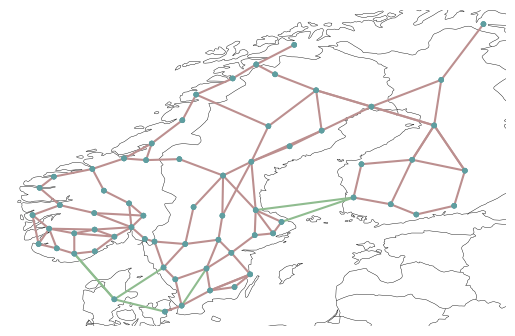

In [2]:
n = pypsa.Network("base_s_65_elec_.nc")
n.plot()


2. Assign zone column to loads. Drop H2 and battery buses. Adding generators with carrier 'other' to every bus, and 'ror' to NO_3 and NO_4. Adding load_Weight for buses and producdtion weight for generators.

✅ Added 65 new 'other' PQ generators.
Found 6 buses in NO_3
Found 6 buses in NO_4


c:\Users\aleks\Documents\UsN\FM4017 - Project\FM4017-Project Repo Aleks\FM4017-Project\Plotting.py:174: DeprecatedWarning:

plot is deprecated as of 0.34 and will be removed in 1.0. Use `n.plot.map()` as a drop-in replacement instead.



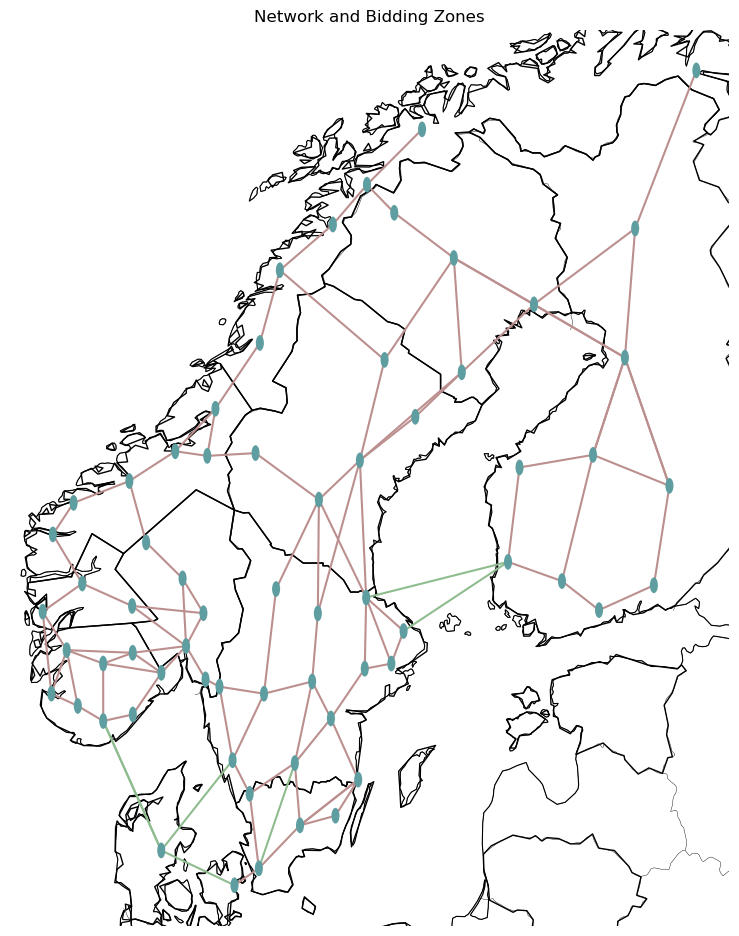

In [3]:
n = assign_zones(n)

drop_buses(n)
add_other_generators_Nordic(n)
add_ror_generators_NO(n)

load_weight(n)
#n.buses
#Replace with production_weighting evetually. Needs to be done after we have added generators we want to include in the share calculation.
production_weight(n)
storage_weight(n)
#n.generators
#n.generators.columns ok now. No Zone or Technology yet
#n.storage_units.columns



plot_network_simple(n)


3. Remove all from node in west denmark and add a slack generator

In [4]:
dk_1_cleanup(n)

Found 1 buses in DK_1 zone
Removed 10 generators from DK0 0
Removed 1 loads from DK0 0
✅ Added slack generator to DK0 0


4. Fetch the ENTSOE-E data regarding AC flow, DC flow, load and production per bidding zone. Can be very time consuming, think about wether you need to do this or not. 
Use this if you want to collect data from other dates. Set run_fetch_entsoe = True if you want to run API call.
Use load from csv cells if you do not want to use other dates. 

In [5]:
run_fetch_entsoe = False
if run_fetch_entsoe:
    loads_df, gens_df, ac_flows_df, dc_flows_df = fetch_entsoe_data(start_date="2023-01-04", timezone="Europe/Oslo")
    loads_df.to_csv("loads_df_summer.csv")
    gens_df.to_csv("gens_df_summer.csv")
    ac_flows_df.to_csv("ac_flows_df_summer.csv")
    dc_flows_df.to_csv("dc_flows_df_summer.csv")
    season = "summer"

#Use save_multiindex_csv and load_multiindex_csv to save and load DataFrames with MultiIndex columns. Load we use anyways. Save you use if you want to save the data you collect using API. 
def save_multiindex_csv(df, filename):
    df.to_csv(filename, index=True)

def load_multiindex_csv(filename):
    return pd.read_csv(filename, header=[0, 1], index_col=0, parse_dates=True)



In [6]:
season = "winter"  # Change to "summer" for summer data, change to some random string if you want to use user specific data. 
if season == "winter":
    loads_df = pd.read_csv("loads_df_winter.csv", index_col=0, parse_dates=True)
    ac_flows_df = pd.read_csv("ac_flows_df_winter.csv", index_col=0, parse_dates=True)
    dc_flows_df = pd.read_csv("dc_flows_df_winter.csv", index_col=0, parse_dates=True)
    gens_df = load_multiindex_csv("gens_df_winter.csv")
    n.set_snapshots(gens_df.index)

elif season == "summer":
    loads_df = pd.read_csv("loads_df_summer.csv", index_col=0, parse_dates=True)
    ac_flows_df = pd.read_csv("ac_flows_df_summer.csv", index_col=0, parse_dates=True)
    dc_flows_df = pd.read_csv("dc_flows_df_summer.csv", index_col=0, parse_dates=True)
    gens_df = load_multiindex_csv("gens_df_summer.csv")
    n.set_snapshots(gens_df.index)

else: 
    loads_df = pd.read_csv("loads_df_user_specific.csv", index_col=0, parse_dates=True)
    ac_flows_df = pd.read_csv("ac_flows_df_user_specific.csv", index_col=0, parse_dates=True)
    dc_flows_df = pd.read_csv("dc_flows_df_user_specificr.csv", index_col=0, parse_dates=True)
    gens_df = load_multiindex_csv("gens_df_user_specific.csv")
    n.set_snapshots(gens_df.index)

print("You have chosen {} data.".format(season))

You have chosen winter data.


5. Merging technologies that couldnt be distributed into Technology: "Other" in gens_df. Needs to be done after you have a dataframe for generation. 

In [7]:
merge_technologies(gens_df, print_what_is_done=False)

6. Add nodes with a slack generator per country. Add slack to SE1 16 for Forsmark. I think we need to add a if test to see if this has already been run, as lpf need unique indexes. I think this can add the same index several times if one runs the cell more than once. 

In [8]:
add_slack_generators(n, nordic_slack_bus='SE1 16', nordic_slack_name=f"slack_Forsmark")

 Added buses: ['DE', 'NL', 'GB', 'PL', 'LT', 'EE']
Added slack_Forsmark to Nordic area at bus SE1 16


7. Add DC links between nordic and non-nordic countries

In [9]:
DC_links_add(n, r"links_needed.csv")

Index(['relation/8184629-300-DC'], dtype='object')


Missing buses: {'way/98216482', 'way/24534144'}


Index(['relation/8184629-300-DC'], dtype='object')


PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 71
 - Carrier: 25
 - Generator: 453
 - Line: 101
 - Link: 15
 - Load: 64
 - StorageUnit: 62
Snapshots: 24

Checking capacity for each technology for each bidding zone. Use to document network in report. We could probably write this to a csv for easier implementation in rep. 

In [10]:
capacity_check_per_zone(n)

save_loading = False
if save_loading:
    capacity_gen, capacity_storage = capacity_check_per_zone(n)
    capacity_gen.to_csv("Result_generator_capacity.csv", index=True)
    capacity_storage.to_csv("Result_storage_units_capacity.csv", index=True)



CCGT
PHS
biomass
coal
hydro
nuclear
offwind-ac
offwind-dc
offwind-float
oil
onwind
other
ror
slack
solar
solar-hsat

Total technologies: 16

Generators capacity (MW) by zone and technology:
carrier    CCGT  biomass    coal  nuclear  offwind-ac  offwind-dc  \
zone                                                                
DK_2     1038.0    311.0  1266.0      0.0      1050.0         0.0   
FI       2709.6   3226.9  1661.8   4362.0        73.0         0.0   
NO_1        0.0      0.0     0.0      0.0         0.0         0.0   
NO_2        0.0      0.0     0.0      0.0        50.0         0.0   
NO_3        0.0      0.0     0.0      0.0         0.0         0.0   
NO_4      459.0      0.0     0.0      0.0         0.0         0.0   
NO_5      294.0      0.0     0.0      0.0        88.0         0.0   
SE_1        0.0     35.0     0.0      0.0        10.3         0.0   
SE_2        0.0    245.0     0.0      0.0         2.3         0.0   
SE_3       50.0    664.0     0.0   8617.0        53

Lots of stuff. Mapping ENTSO-E to carrier. Distributing generation and loads based of weighting factor. 

In [11]:
distribute_generation_load(n, gens_df, loads_df)

✅ distributed: Zone=DK_2 Tech=Biomass Units=1
✅ distributed: Zone=DK_2 Tech=Fossil Gas Units=1
✅ distributed: Zone=DK_2 Tech=Fossil Hard coal Units=1
✅ distributed: Zone=DK_2 Tech=Solar Units=2
✅ distributed: Zone=DK_2 Tech=Wind Offshore Units=3
✅ distributed: Zone=DK_2 Tech=Wind Onshore Units=1
✅ distributed: Zone=FI Tech=Biomass Units=9
✅ distributed: Zone=FI Tech=Fossil Gas Units=7
✅ distributed: Zone=FI Tech=Fossil Hard coal Units=4
✅ distributed: Zone=FI Tech=Hydro Run-of-river and poundage Units=7
✅ distributed: Zone=FI Tech=Nuclear Units=2
✅ distributed: Zone=FI Tech=Other Units=9
✅ distributed: Zone=FI Tech=Solar Units=16
✅ distributed: Zone=FI Tech=Wind Onshore Units=9
✅ distributed: Zone=NO_1 Tech=Hydro Run-of-river and poundage Units=2
✅ distributed: Zone=NO_1 Tech=Wind Onshore Units=5
✅ distributed: Zone=NO_2 Tech=Hydro Run-of-river and poundage Units=1
✅ distributed: Zone=NO_2 Tech=Wind Onshore Units=8
✅ distributed: Zone=NO_3 Tech=Hydro Run-of-river and poundage Units=6
✅

Checking how large the difference between the actual production and the distributed production is. For quality control and adjustment of distribution function. If diff is large, user needs to look at the distribution of generation. 

In [12]:
expected_vals = gens_df.sum(axis=1)
actual_vals = n.generators_t.p_set.sum(axis=1) + n.storage_units_t.p_set.clip(lower=0).sum(axis=1)
diff = actual_vals - expected_vals
diff


snapshot
2023-01-02 00:00:00   -1.000000e-02
2023-01-02 01:00:00   -2.182787e-11
2023-01-02 02:00:00    0.000000e+00
2023-01-02 03:00:00    0.000000e+00
2023-01-02 04:00:00   -1.000000e-02
2023-01-02 05:00:00    0.000000e+00
2023-01-02 06:00:00   -1.000000e-02
2023-01-02 07:00:00    1.455192e-11
2023-01-02 08:00:00   -7.275958e-12
2023-01-02 09:00:00   -7.275958e-12
2023-01-02 10:00:00   -1.455192e-11
2023-01-02 11:00:00    7.275958e-12
2023-01-02 12:00:00    0.000000e+00
2023-01-02 13:00:00    0.000000e+00
2023-01-02 14:00:00    7.275958e-12
2023-01-02 15:00:00   -1.455192e-11
2023-01-02 16:00:00    0.000000e+00
2023-01-02 17:00:00    1.455192e-11
2023-01-02 18:00:00    7.275958e-12
2023-01-02 19:00:00    7.275958e-12
2023-01-02 20:00:00   -1.000000e-02
2023-01-02 21:00:00   -1.000000e-02
2023-01-02 22:00:00    1.455192e-11
2023-01-02 23:00:00    1.455192e-11
dtype: float64

Checking how large the difference between the actual load and the distributed load is. For quality control and adjustment of distribution function. If diff is large, user needs to look at the distribution of load. 

In [13]:
expected_vals = loads_df.sum(axis=1)
actual_vals = n.loads_t.p_set.sum(axis=1)
diff = actual_vals - expected_vals
diff

snapshot
2023-01-02 00:00:00   -7.275958e-12
2023-01-02 01:00:00    2.182787e-11
2023-01-02 02:00:00   -7.275958e-12
2023-01-02 03:00:00    0.000000e+00
2023-01-02 04:00:00   -7.275958e-12
2023-01-02 05:00:00   -2.910383e-11
2023-01-02 06:00:00   -7.275958e-12
2023-01-02 07:00:00    7.275958e-12
2023-01-02 08:00:00    7.275958e-12
2023-01-02 09:00:00   -7.275958e-12
2023-01-02 10:00:00    7.275958e-12
2023-01-02 11:00:00    2.182787e-11
2023-01-02 12:00:00    0.000000e+00
2023-01-02 13:00:00    0.000000e+00
2023-01-02 14:00:00    1.455192e-11
2023-01-02 15:00:00   -7.275958e-12
2023-01-02 16:00:00   -7.275958e-12
2023-01-02 17:00:00   -7.275958e-12
2023-01-02 18:00:00    7.275958e-12
2023-01-02 19:00:00   -2.182787e-11
2023-01-02 20:00:00    7.275958e-12
2023-01-02 21:00:00    0.000000e+00
2023-01-02 22:00:00    1.455192e-11
2023-01-02 23:00:00    7.275958e-12
dtype: float64

DC-link stuff happening below

In [14]:
dc_links_modifications_power_distr(n, dc_flows_df)

Column DK_1<->NL not found in network links.
Column SE_3<->SE_4 not found in network links.
False
Column DK_1<->NL not found in network links.
Column SE_3<->SE_4 not found in network links.


In [41]:
n.lpf()


INFO:pypsa.network.power_flow:Performing linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000001C575ADF230> for snapshot(s) DatetimeIndex(['2023-01-02 00:00:00', '2023-01-02 01:00:00',
               '2023-01-02 02:00:00', '2023-01-02 03:00:00',
               '2023-01-02 04:00:00', '2023-01-02 05:00:00',
               '2023-01-02 06:00:00', '2023-01-02 07:00:00',
               '2023-01-02 08:00:00', '2023-01-02 09:00:00',
               '2023-01-02 10:00:00', '2023-01-02 11:00:00',
               '2023-01-02 12:00:00', '2023-01-02 13:00:00',
               '2023-01-02 14:00:00', '2023-01-02 15:00:00',
               '2023-01-02 16:00:00', '2023-01-02 17:00:00',
               '2023-01-02 18:00:00', '2023-01-02 19:00:00',
               '2023-01-02 20:00:00', '2023-01-02 21:00:00',
               '2023-01-02 22:00:00', '2023-01-02 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.network.power_flow:Performing linear load

Displaying line and link relative loading [%], loading [MW] and capacity [MW].

In [16]:
pd.set_option('display.width', None)           # Don't wrap lines
pd.set_option('display.max_columns', None)     # Show all columns
pd.set_option('display.max_colwidth', None)    # Don't truncate long strings
pd.set_option('display.colheader_justify', 'left')  # Align headers neatly
pd.set_option('display.expand_frame_repr', False)   # Keep one-line rows
loading_lines_and_links_relative_quantified(n, snapshot_number=17, number_of_displayed_links=len(n.links), number_of_displayed_lines=15)

save_loading = False
if save_loading:
    loading_lines, loading_links = loading_lines_and_links_relative_quantified(n, snapshot_number=17, number_of_displayed_links=len(n.links), number_of_displayed_lines=15)
    loading_lines.to_csv("Result_loading_lines_summer.csv", index=True)
    loading_links.to_csv("Result_loading_links_summer.csv", index=True)
pd.reset_option('all')





 Zero loaded components:
Zero-loaded AC Lines: 0
Zero-loaded HVDC Links: 2

 AC lines loading
   bus0    zone_bus0 bus1    zone_bus1  loading_percent  loading_MW   rated_capacity_MW type    
38  NO1 16  NO_1      NO1 26  NO_1      62.240763         625.803168  1005.455494        AC Line
54  NO1 24  NO_3       NO1 6  NO_3      54.320093        1565.671173  2882.305749        AC Line
57  NO1 26  NO_1       NO1 6  NO_3      52.265876         525.510121  1005.455494        AC Line
40  NO1 17  NO_4       NO1 2  NO_4      50.540233        1456.724050  2882.305749        AC Line
43  NO1 18  NO_3       NO1 2  NO_4      47.292907        1363.126176  2882.305749        AC Line
72  SE1 14  SE_1       SE1 3  SE_1      46.782309         836.222757  1787.476433        AC Line
78  SE1 16  SE_3       SE1 4  SE_2      45.956727        2690.300045  5853.985319        AC Line
97  SE1 25  SE_3       SE1 4  SE_2      41.995894         750.666711  1787.476433        AC Line
74  SE1 15  SE_2      SE1 25  SE

C:\Users\aleks\AppData\Local\Temp\ipykernel_25752\776512482.py:13: FutureWarning:

data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.

C:\Users\aleks\AppData\Local\Temp\ipykernel_25752\776512482.py:13: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\aleks\AppData\Local\Temp\ipykernel_25752\776512482.py:13: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Plotting the network with bidding zones, line loading and link loading. Arrows indicates power flow direction. 

c:\Users\aleks\Documents\UsN\FM4017 - Project\FM4017-Project Repo Aleks\FM4017-Project\Plotting.py:52: DeprecatedWarning:

plot is deprecated as of 0.34 and will be removed in 1.0. Use `n.plot.map()` as a drop-in replacement instead.



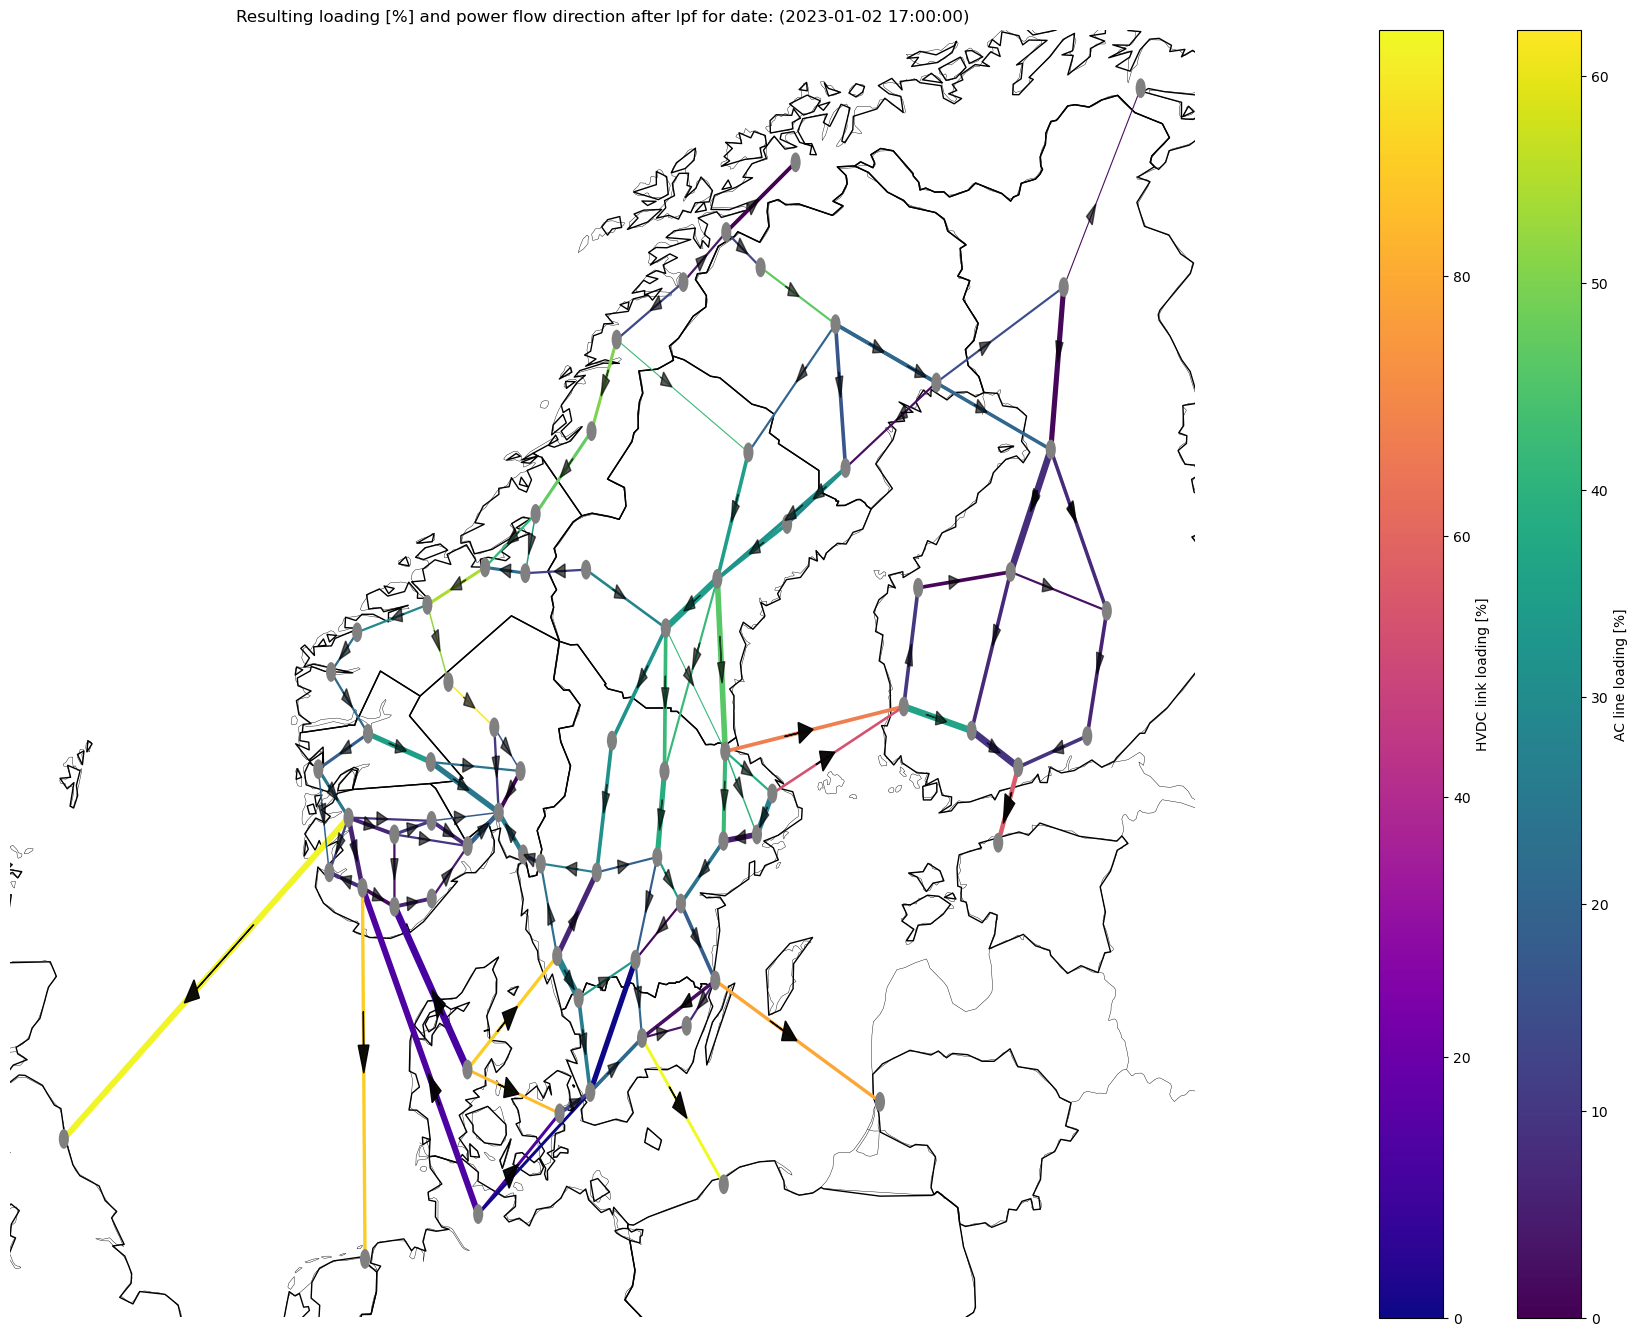

In [17]:
#Specify what max line capacity you want to use for normalization. 1 line in Finland is very capable, and if we don't specify normalization value ourselves, 
#the other lines look really small
plot_network_with_loadings(n, snapshot_number=17, normalization_val_lines=7500) 

In [18]:
# 7. Network summary and verification

print("=== NETWORK SUMMARY ===")
print(f"Buses: {len(n.buses)}")
print(f"Generators: {len(n.generators)}")
print(f"Links: {len(n.links)}")
print(f"Lines: {len(n.lines)}")
print(f"Loads: {len(n.loads)}")
print("\n=== NORDIC SYNC GRID BUSES ===")

"""nordic_sync_buses = ["DE", "NL"]
for bus in nordic_sync_buses:
    if bus in n.buses.index:
        print(f"✅ {bus}: {n.buses.loc[bus, 'v_nom']} kV")"""



print("\n=== SLACK GENERATORS ===")
slack_gens = (n.generators[n.generators['carrier'] == 'slack'])
print(f"Total slack generators: {len(slack_gens)}")
print("   - No p_nom specified (PyPSA handles automatically)")
print("   - DK_1 cleaned: all generators, loads, storage units removed")
print("   - One slack generator added to DK_1")

# Count buses per zone
bus_counts = n.buses['zone'].value_counts()

# Count generators per zone
gen_counts = n.generators['zone'].value_counts()

# Combine into one DataFrame
zone_summary = pd.DataFrame({
    'Number of Buses': bus_counts,
    'Number of Generators': gen_counts
}).fillna(0).astype(int)  # Fill missing with 0 and convert to int

# Sort by zone name (optional, for readability)
zone_summary = zone_summary.sort_index()

print(zone_summary)
print(n.generators[n.generators['control'] == 'Slack'])

=== NETWORK SUMMARY ===
Buses: 71
Generators: 453
Links: 14
Lines: 101
Loads: 64

=== NORDIC SYNC GRID BUSES ===

=== SLACK GENERATORS ===
Total slack generators: 8
   - No p_nom specified (PyPSA handles automatically)
   - DK_1 cleaned: all generators, loads, storage units removed
   - One slack generator added to DK_1
      Number of Buses  Number of Generators
zone                                       
DK_1                1                     0
DK_2                1                    10
FI                  9                    92
NO_1                5                    26
NO_2                8                    47
NO_3                6                    44
NO_4                6                    37
NO_5                3                    21
SE_1                4                    19
SE_2                5                    32
SE_3               13                    86
SE_4                4                    31
                   bus control type      p_nom  p_nom_mod  p_n

In [19]:
print(n.lines_t.p0['57'])
n.buses.zone == 'NO_3'
n.buses[n.buses.zone == 'NO_3']
n.links_t


snapshot
2023-01-02 00:00:00   -394.346538
2023-01-02 01:00:00   -373.881684
2023-01-02 02:00:00   -346.114988
2023-01-02 03:00:00   -320.493370
2023-01-02 04:00:00   -325.047245
2023-01-02 05:00:00   -355.202085
2023-01-02 06:00:00   -429.021802
2023-01-02 07:00:00   -441.938206
2023-01-02 08:00:00   -436.706155
2023-01-02 09:00:00   -504.024522
2023-01-02 10:00:00   -480.406293
2023-01-02 11:00:00   -513.589121
2023-01-02 12:00:00   -508.306601
2023-01-02 13:00:00   -513.517510
2023-01-02 14:00:00   -581.222300
2023-01-02 15:00:00   -547.532947
2023-01-02 16:00:00   -491.998940
2023-01-02 17:00:00   -525.510121
2023-01-02 18:00:00   -553.285955
2023-01-02 19:00:00   -559.725682
2023-01-02 20:00:00   -567.015751
2023-01-02 21:00:00   -564.085489
2023-01-02 22:00:00   -501.404704
2023-01-02 23:00:00   -473.457674
Name: 57, dtype: float64


{'efficiency': Empty DataFrame
 Columns: []
 Index: [2023-01-02 00:00:00, 2023-01-02 01:00:00, 2023-01-02 02:00:00, 2023-01-02 03:00:00, 2023-01-02 04:00:00, 2023-01-02 05:00:00, 2023-01-02 06:00:00, 2023-01-02 07:00:00, 2023-01-02 08:00:00, 2023-01-02 09:00:00, 2023-01-02 10:00:00, 2023-01-02 11:00:00, 2023-01-02 12:00:00, 2023-01-02 13:00:00, 2023-01-02 14:00:00, 2023-01-02 15:00:00, 2023-01-02 16:00:00, 2023-01-02 17:00:00, 2023-01-02 18:00:00, 2023-01-02 19:00:00, 2023-01-02 20:00:00, 2023-01-02 21:00:00, 2023-01-02 22:00:00, 2023-01-02 23:00:00],
 'p_set': Link                 Fenno-Skan 2  Storebaelt  Konti-Skan  Fenno-Skan 1  \
 snapshot                                                                  
 2023-01-02 00:00:00      387.4677     -587.99      370.88      190.8423   
 2023-01-02 01:00:00      387.4945     -430.44      379.11      190.8555   
 2023-01-02 02:00:00      387.4610     -530.79      590.05      190.8390   
 2023-01-02 03:00:00      387.3203     -444.96      5

In [20]:
# Group by bus + carrier and sum installed nominal power
capacity_by_bus_and_carrier = (
    n.generators
    .groupby(["bus", "carrier"])["p_nom"]
    .sum()
    .unstack(fill_value=0)
)

#print(capacity_by_bus_and_carrier)


In [21]:
# Ensure generators have zone mapped
n.generators["zone"] = n.generators["bus"].map(n.buses["zone"])
zone = "SE_3"

# Filter generators in that zone
gens_in_zone = n.generators[n.generators["zone"] == zone]

# Group by carrier → sum timeseries for each carrier separately
production_by_carrier = (
    n.generators_t.p[gens_in_zone.index]
    .groupby(gens_in_zone["carrier"], axis=1)
    .sum()
)

#print(production_by_carrier)

C:\Users\aleks\AppData\Local\Temp\ipykernel_25752\490442407.py:11: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [22]:
a = n.generators_t.p_set

# Group by carrier (use mapping from generator names → carrier)
prod_per_carrier = a.groupby(n.generators["carrier"], axis=1).sum()

print(prod_per_carrier.head(24))



carrier                CCGT  biomass    coal  nuclear  offwind-ac  offwind-dc  \
snapshot                                                                        
2023-01-02 00:00:00  413.36  1035.00  767.52  10168.5      603.22         0.0   
2023-01-02 01:00:00  405.50   992.80  769.48  10167.9      476.35         0.0   
2023-01-02 02:00:00  411.82   997.56  768.41  10167.0      495.58         0.0   
2023-01-02 03:00:00  421.06  1014.35  770.81  10169.5      507.55         0.0   
2023-01-02 04:00:00  406.73  1032.37  779.62  10168.2      350.37         0.0   
2023-01-02 05:00:00  414.93  1172.03  848.43  10167.1      361.17         0.0   
2023-01-02 06:00:00  426.96  1253.04  891.60  10166.5      417.29         0.0   
2023-01-02 07:00:00  437.60  1275.95  910.16  10169.2      632.88         0.0   
2023-01-02 08:00:00  440.11  1291.70  918.36  10169.4      835.95         0.0   
2023-01-02 09:00:00  434.12  1301.25  924.61   9776.1      905.13         0.0   
2023-01-02 10:00:00  482.05 

C:\Users\aleks\AppData\Local\Temp\ipykernel_25752\3690390782.py:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [23]:
prod_per_tech = gens_df.groupby(level="Technology", axis=1).sum()
#print(prod_per_tech.head(24))

#Do this for n.generators_t aswell to see slack production

C:\Users\aleks\AppData\Local\Temp\ipykernel_25752\863209335.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [24]:
# Group time-dependent generation by carrier only
prod_per_carrier = (
    n.generators_t.p
    .groupby(n.generators["carrier"], axis=1)
    .sum()
)

# Show the first 24 timesteps
#print(prod_per_carrier.head(24))


C:\Users\aleks\AppData\Local\Temp\ipykernel_25752\3836803504.py:4: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Finding production for the slack generators. Just to see that something actually happens. 

In [25]:
# 1️⃣ Find buses without zone
buses_without_zone = n.buses[n.buses["zone"].isna() | (n.buses["zone"] == "")]
bus_list = buses_without_zone.index.tolist()

print(f"=== Buses without zone ({len(bus_list)}) ===")
print(bus_list)

# 2️⃣ Find generators connected to those buses
gens_without_zone = n.generators[n.generators["bus"].isin(bus_list)]

print(f"\n=== Generators connected to unzoned buses ({len(gens_without_zone)}) ===")
if gens_without_zone.empty:
    print("✅ No generators connected to unzoned buses.")
else:
    print(gens_without_zone[["bus", "carrier", "p_nom"]])

    # 3️⃣ Show their production time series
    # Choose either p (actual dispatch) or p_set (setpoint / target)
    gen_names = gens_without_zone.index
    production_ts = n.generators_t.p.loc[:, gen_names]

    print("\n=== Production of generators connected to unzoned buses ===")
    print(production_ts.head(24))  # first 24 hours (or snapshots)


n.generators.loc["slack_Forsmark"]

slack_gens = n.generators[n.generators["carrier"] == "slack"]
p_slack = n.generators_t.p[slack_gens.index]
slack_prod_per_zone = p_slack.groupby(slack_gens["zone"], axis=1).sum()

print(slack_prod_per_zone.head(100))

n.generators.columns

=== Buses without zone (6) ===
['DE', 'NL', 'GB', 'PL', 'LT', 'EE']

=== Generators connected to unzoned buses (6) ===
          bus carrier  p_nom
Generator                   
slack_DE   DE   slack    0.0
slack_NL   NL   slack    0.0
slack_GB   GB   slack    0.0
slack_PL   PL   slack    0.0
slack_LT   LT   slack    0.0
slack_EE   EE   slack    0.0

=== Production of generators connected to unzoned buses ===
Generator             slack_DE  slack_NL  slack_GB  slack_PL  slack_LT  \
snapshot                                                                 
2023-01-02 00:00:00   884.3400  649.0900  -1253.83   -597.30   -310.53   
2023-01-02 01:00:00   979.1925  649.0900  -1260.00   -597.30   -191.70   
2023-01-02 02:00:00  1195.2125  649.0900  -1260.00   -597.40    -72.84   
2023-01-02 03:00:00  1573.3325  649.0900  -1265.33   -588.40   -305.40   
2023-01-02 04:00:00  1531.9250  649.0900  -1357.97   -150.70   -472.03   
2023-01-02 05:00:00  1791.4925  634.6900  -1011.43   -530.40   -667.03

C:\Users\aleks\AppData\Local\Temp\ipykernel_25752\3491747872.py:30: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Index(['bus', 'control', 'type', 'p_nom', 'p_nom_mod', 'p_nom_extendable',
       'p_nom_min', 'p_nom_max', 'p_min_pu', 'p_max_pu', 'p_set', 'e_sum_min',
       'e_sum_max', 'q_set', 'sign', 'carrier', 'marginal_cost',
       'marginal_cost_quadratic', 'active', 'build_year', 'lifetime',
       'capital_cost', 'efficiency', 'committable', 'start_up_cost',
       'shut_down_cost', 'stand_by_cost', 'min_up_time', 'min_down_time',
       'up_time_before', 'down_time_before', 'ramp_limit_up',
       'ramp_limit_down', 'ramp_limit_start_up', 'ramp_limit_shut_down',
       'weight', 'p_nom_opt', 'zone', 'production_share'],
      dtype='object')

Testing cells below. For results. Power flow results sometimes differ wildly from the expected ones. Look at this together. 

In [26]:
import pandas as pd
import numpy as np

def compute_crossborder_flows_ac(n, snapshot_index=17):
    """
    Compute net cross-border AC flows (MW) between zones at a given snapshot index.
    Positive = net flow from zone0 → zone1 (direction based on alphabetical order of zones).
    """

    # --- Select snapshot ---
    snapshot = n.snapshots[snapshot_index]

    # --- Map buses to zones ---
    bus_zones = n.buses["zone"].to_dict()

    # --- AC lines that connect different zones ---
    line_df = n.lines.copy()
    line_df["zone0"] = line_df["bus0"].map(bus_zones)
    line_df["zone1"] = line_df["bus1"].map(bus_zones)

    cross_lines = line_df[line_df["zone0"] != line_df["zone1"]].copy()
    if cross_lines.empty:
        print("No cross-border AC lines found.")
        return pd.DataFrame()

    # --- Power flow (MW) for selected snapshot ---
    p0 = n.lines_t.p0.loc[snapshot, cross_lines.index]
    cross_lines["flow_MW"] = p0

    # --- Define *directed* pairs based on alphabetical order ---
    def ordered_flow(row):
        # Always order zones alphabetically to keep one direction per pair
        zoneA, zoneB = sorted([row["zone0"], row["zone1"]])
        # If the alphabetical order reverses original direction, invert sign
        sign = 1 if (row["zone0"] == zoneA) else -1
        return pd.Series({"zoneA": zoneA, "zoneB": zoneB, "flow_MW": row["flow_MW"] * sign})

    ordered = cross_lines.apply(ordered_flow, axis=1)

    # --- Sum up all lines between each zone pair ---
    flows = (
        ordered.groupby(["zoneA", "zoneB"])["flow_MW"]
        .sum()
        .rename("AC_flow_MW")
        .to_frame()
    )

    # --- Sort for readability ---
    return flows.sort_index()



In [27]:
flows = compute_crossborder_flows_ac(n, snapshot_index=0)

# Drop rows by integer position (row 1 and 2)
flows_dropped = flows.reset_index().drop([1, 2])

print("\n=== Cross-border flows (MW) ===")
print(flows_dropped)
#flows_dropped.iloc[0,2]

total_trans = flows_dropped['AC_flow_MW'].abs().sum()
total_trans



=== Cross-border flows (MW) ===
   zoneA zoneB   AC_flow_MW
0   DK_2  SE_4  -943.120000
3   NO_1  NO_2 -1119.033107
4   NO_1  NO_3  -394.346538
5   NO_1  NO_5  -249.139362
6   NO_1  SE_3 -1573.590993
7   NO_2  NO_5   222.686893
8   NO_3  NO_4 -1288.696682
9   NO_3  NO_5   340.512469
10  NO_3  SE_2  -635.252325
11  NO_4  SE_1    95.035739
12  NO_4  SE_2    88.836476
13  SE_1  SE_2  2070.506842
14  SE_2  SE_3  4136.180993
15  SE_3  SE_4  2387.500000


15544.438418301872

In [28]:
test = ac_flows_df.iloc[0]
print(test)

total_trans = test.abs().sum(axis=0)
total_trans

DK_2<->SE_4   -1022.03
NO_1<->NO_2   -1176.01
NO_1<->NO_3       0.00
NO_1<->NO_5    -343.37
NO_1<->SE_3   -1748.94
NO_2<->NO_5     133.64
NO_3<->NO_4   -1258.90
NO_3<->NO_5     498.53
NO_3<->SE_2    -382.49
NO_4<->SE_1     196.95
NO_4<->SE_2      27.50
SE_1<->SE_2    2764.11
SE_2<->SE_3    5076.70
SE_3<->SE_4    2690.40
Name: 2023-01-02 00:00:00, dtype: float64


17319.57

In [29]:
test.iloc[0]

-1022.03

In [30]:
diff_list = []

for i in range(len(flows_dropped)):
    value = flows_dropped.iloc[i, 2] - test.iloc[i]
    diff_list.append(value)

# Convert to Series if you like:
diff_series = pd.Series(diff_list, index=flows_dropped.index)
print(diff_series)

0      78.910000
3      56.976893
4    -394.346538
5      94.230638
6     175.349007
7      89.046893
8     -29.796682
9    -158.017531
10   -252.762325
11   -101.914261
12     61.336476
13   -693.603158
14   -940.519007
15   -302.900000
dtype: float64


In [31]:
# Percent deviation
diff_list = []

for i in range(len(flows_dropped)):
    value = (flows_dropped.iloc[i, 2] - test.iloc[i])/test.iloc[i] * 100
    diff_list.append(value)

# Convert to Series if you like:
diff_series = pd.Series(diff_list, index=flows_dropped.index)
print(diff_series)

avg = diff_series.mean()
print(avg)

0      -7.720908
3      -4.844933
4           -inf
5     -27.442886
6     -10.026016
7      66.631916
8       2.366882
9     -31.696694
10     66.083381
11    -51.746261
12    223.041730
13    -25.093182
14    -18.526188
15    -11.258549
dtype: float64
-inf


C:\Users\aleks\AppData\Local\Temp\ipykernel_25752\2640730439.py:5: RuntimeWarning:

divide by zero encountered in scalar divide



Calculating the average error over all cross border flows. In this code we exclude error > 100 %, as there are many extremes dragging up the average. Sambeet agreed this could be done. 

In [32]:
# Average error over the entire 24-hour period
aggregated_err = 0

for i in range(24):  # snapshot index 0–23
    # --- Modelled flow at snapshot i ---
    flows_i = compute_crossborder_flows_ac(n, snapshot_index=i)

    # --- Drop unwanted rows ---
    flows_dropped_i = flows_i.reset_index().drop([1, 2])

    # --- Actual measured flows for same snapshot ---
    actual_flow = ac_flows_df.iloc[i]  # Series of actual flows for all zone pairs

    # --- Add zone pair identifier for alignment ---
    flows_dropped_i["pair"] = flows_dropped_i["zoneA"] + "<->" + flows_dropped_i["zoneB"]
    flows_dropped_i = flows_dropped_i.set_index("pair")

    # --- Prepare for inner loop ---
    diff_list = []

    for j in range(len(flows_dropped_i)):
        pair_name = flows_dropped_i.index[j]

        # Skip if this pair not in actual data
        if pair_name not in actual_flow.index:
            continue

        model_val = flows_dropped_i.iloc[j, 2]  # "AC_flow_MW"
        actual_val = actual_flow.loc[pair_name]

        # Guard against divide-by-zero
        if actual_val == 0:
            continue

        # Percent deviation
        value = (model_val - actual_val) / abs(actual_val) * 100

        # Exclude extreme errors (> 100%)
        if abs(value) > 100:
            continue

        diff_list.append(value)

    # --- Convert differences to Series for this snapshot ---
    diff_series = pd.Series(diff_list)
    print(f"\n=== Snapshot {i} ===")
    print(diff_series)

    # --- Aggregate mean absolute error for this snapshot ---
    if not diff_series.empty:
        aggregated_err += diff_series.abs().mean()

# --- Average over 24 snapshots ---
avg_err = aggregated_err / 24
print("\nAverage percentage deviation across all snapshots (excluding >100% errors):")
print(f"{avg_err:.2f}%")



=== Snapshot 0 ===
0      7.720908
1      4.844933
2     27.442886
3     10.026016
4     66.631916
5     -2.366882
6    -31.696694
7    -66.083381
8    -51.746261
9    -25.093182
10   -18.526188
11   -11.258549
dtype: float64

=== Snapshot 1 ===
0      7.779706
1     17.993577
2     47.247637
3     -2.234126
4     49.108011
5     -1.121749
6    -33.925927
7    -63.397565
8    -63.297054
9    -27.119595
10   -25.258221
11    -7.326117
dtype: float64

=== Snapshot 2 ===
0     11.838116
1     13.166310
2     88.026707
3      0.585536
4     83.180179
5     -2.018578
6    -43.055337
7    -46.942540
8    -65.706688
9    -28.731418
10   -26.777972
11    -3.976393
dtype: float64

=== Snapshot 3 ===
0     29.025606
1     12.884561
2     85.289418
3      0.124213
4     93.167802
5     -6.148285
6    -45.004641
7    -35.733781
8    -44.566260
9    -25.939493
10   -21.027616
11   -15.110506
dtype: float64

=== Snapshot 4 ===
0      9.846466
1     11.845447
2     54.387322
3      0.870104
4     -5

Code below calculates the cross border flow, and shows which lines are crossing 

In [33]:
import pandas as pd
import numpy as np

def compute_crossborder_flows_ac_2(n, snapshot_index=17):
    """
    Compute net cross-border AC flows (MW) between zones at a given snapshot index.
    Positive = net flow from alphabetically lower zone → higher zone.
    Includes list of contributing line IDs for each zone pair.
    """

    # --- Select snapshot ---
    snapshot = n.snapshots[snapshot_index]

    # --- Map buses to zones ---
    bus_zones = n.buses["zone"].to_dict()

    # --- Identify AC lines crossing different zones ---
    line_df = n.lines.copy()
    line_df["zone0"] = line_df["bus0"].map(bus_zones)
    line_df["zone1"] = line_df["bus1"].map(bus_zones)

    cross_lines = line_df[line_df["zone0"] != line_df["zone1"]].copy()
    if cross_lines.empty:
        print("⚠️ No cross-border AC lines found.")
        return pd.DataFrame()

    # --- Power flow (MW) for selected snapshot ---
    p0 = n.lines_t.p0.loc[snapshot, cross_lines.index]
    cross_lines["flow_MW"] = p0

    # --- Normalize direction by alphabetical order of zones ---
    def ordered_flow(row):
        zoneA, zoneB = sorted([row["zone0"], row["zone1"]])
        sign = 1 if row["zone0"] == zoneA else -1
        return pd.Series({
            "zoneA": zoneA,
            "zoneB": zoneB,
            "flow_MW": row["flow_MW"] * sign,
            "line_name": row.name
        })

    ordered = cross_lines.apply(ordered_flow, axis=1)

    # --- Group by zone pair: sum flow and collect line names ---
    flows = (
        ordered.groupby(["zoneA", "zoneB"])
        .agg(
            AC_flow_MW=("flow_MW", "sum"),
            lines_included=("line_name", lambda x: ", ".join(x))
        )
        .reset_index()
        .sort_values(["zoneA", "zoneB"])
        .set_index(["zoneA", "zoneB"])
    )

    return flows


Maybe use cell below for network quantification? Showing the connection between lines and zones

In [34]:
flows = compute_crossborder_flows_ac_2(n, snapshot_index=17)
print(flows.reset_index())


   zoneA zoneB   AC_flow_MW          lines_included
0   DK_2  SE_4   494.857500                       0
1     FI  NO_4    10.720097                      12
2     FI  SE_1 -1310.175097                13, 8, 9
3   NO_1  NO_2 -1083.070495                  27, 29
4   NO_1  NO_3  -525.510121                      57
5   NO_1  NO_5 -1886.252377                  18, 20
6   NO_1  SE_3  -609.377007                      53
7   NO_2  NO_5  -947.370495                  52, 58
8   NO_3  NO_4 -1363.126176                      43
9   NO_3  NO_5   392.512872                      31
10  NO_3  SE_2  -221.136817                      59
11  NO_4  SE_1   234.153243                      34
12  NO_4  SE_2   204.370677                      42
13  SE_1  SE_2  2512.568147              70, 89, 96
14  SE_2  SE_3  6289.482007      62, 73, 74, 78, 97
15  SE_3  SE_4  2012.462500  65, 81, 82, 83, 91, 92


In [35]:
# Map each bus to its zone
bus_zones = n.buses["zone"].to_dict()

# Create columns for the zones of each end of the line
n.lines["zone0"] = n.lines["bus0"].map(bus_zones)
n.lines["zone1"] = n.lines["bus1"].map(bus_zones)

# Filter for lines where bus0 is in NO_2 and bus1 is in NO_5
mask = (n.lines["zone0"] == "SE_3") & (n.lines["zone1"] == "SE_4")
lines_NO2_NO5 = n.lines[mask]

print("=== Lines with bus0 in NO_2 and bus1 in NO_5 ===")
print(lines_NO2_NO5)


=== Lines with bus0 in NO_2 and bus1 in NO_5 ===
        bus0    bus1                         type          x         r    g  \
Line                                                                          
65    SE1 10  SE1 22  Al/St 240/40 4-bundle 380.0   4.447922  0.542429  0.0   
81    SE1 17   SE1 5  Al/St 240/40 4-bundle 380.0  35.992125  4.389284  0.0   
82    SE1 17   SE1 5  Al/St 240/40 4-bundle 380.0  18.943197  2.310146  0.0   
83    SE1 17   SE1 9  Al/St 240/40 4-bundle 380.0  20.286540  2.473968  0.0   
91    SE1 21  SE1 22  Al/St 240/40 4-bundle 380.0  26.438359  3.224190  0.0   
92    SE1 21   SE1 5  Al/St 240/40 4-bundle 380.0  29.206854  3.561811  0.0   

             b        s_nom  s_nom_mod  s_nom_extendable  ...  g_pu  \
Line                                                      ...         
65    0.001390  7149.905734        0.0              True  ...   0.0   
81    0.000703  1787.476433        0.0              True  ...   0.0   
82    0.001335  3396.210000       

In [36]:
line_no = '20'
print(n.lines_t.p0[line_no].iloc[17])
print(n.lines.loc[line_no])
print(n.buses.loc['NO1 0'])
#n.buses.zone == 'NO_3'
#n.buses[n.buses.zone == 'NO_3']

442.8851267712952
bus0                                      NO1 0
bus1                                      NO1 5
type                Al/St 240/40 4-bundle 380.0
x                                     30.742695
r                                      3.749109
g                                           0.0
b                                      0.000662
s_nom                               1876.850255
s_nom_mod                                   0.0
s_nom_extendable                           True
s_nom_min                           1876.850255
s_nom_max                          21876.850255
s_max_pu                                    0.7
capital_cost                          15.896673
active                                     True
build_year                                    0
lifetime                                    inf
length                               138.125075
carrier                                      AC
terrain_factor                              1.0
num_parallel          

Looking at how often the model calculates the correct direction of power flow. 

In [37]:
import numpy as np
import pandas as pd

# Track total and correct directions
total_count = 0
correct_count = 0

# Store per-snapshot accuracy (optional)
sign_accuracy = []

for i in range(24):  # assuming 24 snapshots
    # --- Modelled flows ---
    model_flows = compute_crossborder_flows_ac_2(n, snapshot_index=i)
    model_df = model_flows.reset_index()
    model_df["pair"] = model_df["zoneA"] + "<->" + model_df["zoneB"]
    model_df = model_df.set_index("pair")

    # --- Actual measured flows ---
    actual = ac_flows_df.iloc[i]

    # --- Align model and actual zone pairs ---
    common_pairs = model_df.index.intersection(actual.index)
    if common_pairs.empty:
        continue

    model_vals = model_df.loc[common_pairs, "AC_flow_MW"]
    actual_vals = actual.loc[common_pairs]

    # --- Compare signs ---
    sign_match = np.sign(model_vals) == np.sign(actual_vals)
    correct = sign_match.sum()
    total = len(sign_match)

    # --- Track results ---
    correct_count += correct
    total_count += total
    sign_accuracy.append(correct / total * 100)

    print(f"Snapshot {i:02d}: {correct}/{total} ({correct/total*100:.1f}%) correct directions")

# --- Overall accuracy ---
overall_accuracy = correct_count / total_count * 100
print("\n=== Directional accuracy summary ===")
print(f"Total matches: {correct_count}/{total_count}")
print(f"Overall accuracy: {overall_accuracy:.1f}%")

# Optional: average per-snapshot accuracy
print(f"Average per-snapshot accuracy: {np.mean(sign_accuracy):.1f}%")


Snapshot 00: 13/14 (92.9%) correct directions
Snapshot 01: 13/14 (92.9%) correct directions
Snapshot 02: 12/14 (85.7%) correct directions
Snapshot 03: 12/14 (85.7%) correct directions
Snapshot 04: 13/14 (92.9%) correct directions
Snapshot 05: 13/14 (92.9%) correct directions
Snapshot 06: 11/14 (78.6%) correct directions
Snapshot 07: 13/14 (92.9%) correct directions
Snapshot 08: 13/14 (92.9%) correct directions
Snapshot 09: 11/14 (78.6%) correct directions
Snapshot 10: 12/14 (85.7%) correct directions
Snapshot 11: 13/14 (92.9%) correct directions
Snapshot 12: 13/14 (92.9%) correct directions
Snapshot 13: 13/14 (92.9%) correct directions
Snapshot 14: 13/14 (92.9%) correct directions
Snapshot 15: 13/14 (92.9%) correct directions
Snapshot 16: 12/14 (85.7%) correct directions
Snapshot 17: 12/14 (85.7%) correct directions
Snapshot 18: 12/14 (85.7%) correct directions
Snapshot 19: 13/14 (92.9%) correct directions
Snapshot 20: 13/14 (92.9%) correct directions
Snapshot 21: 12/14 (85.7%) correct

In [42]:
n

PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 71
 - Carrier: 25
 - Generator: 453
 - Line: 101
 - Link: 14
 - Load: 64
 - StorageUnit: 62
 - SubNetwork: 8
Snapshots: 24